# Pytorch CNN - Brain Tumor Detection
# https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

# Importing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from PIL import Image
from glob import glob

import sklearn
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms

%matplotlib inline

In [2]:
# Need to check if cuda is avaiable, to shift tensors and network to GPUs
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("Use Cuda")
else:
    device = torch.device('cpu')
    print("Use CPU")

Use Cuda


# Upload data zip file

* local folder에서 colab으로 파일 불러오기

In [20]:
from google.colab import files
# archive.zip 을 선택하면 됩니다.
files_upload = files.upload()

Saving archive.zip to archive (1).zip


In [21]:
!unzip archive.zip

Archive:  archive.zip
replace archive/brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: archive/brain_tumor_dataset/no/1 no.jpeg  
  inflating: archive/brain_tumor_dataset/no/10 no.jpg  
  inflating: archive/brain_tumor_dataset/no/11 no.jpg  
  inflating: archive/brain_tumor_dataset/no/12 no.jpg  
  inflating: archive/brain_tumor_dataset/no/13 no.jpg  
  inflating: archive/brain_tumor_dataset/no/14 no.jpg  
  inflating: archive/brain_tumor_dataset/no/15 no.jpg  
  inflating: archive/brain_tumor_dataset/no/17 no.jpg  
  inflating: archive/brain_tumor_dataset/no/18 no.jpg  
  inflating: archive/brain_tumor_dataset/no/19 no.jpg  
  inflating: archive/brain_tumor_dataset/no/2 no.jpeg  
  inflating: archive/brain_tumor_dataset/no/20 no.jpg  
  inflating: archive/brain_tumor_dataset/no/21 no.jpg  
  inflating: archive/brain_tumor_dataset/no/22 no.jpg  
  inflating: archive/brain_tumor_dataset/no/23 no.jpg  
  inflating: archive/brain_tumor_dataset/no/24 n

In [22]:
file_dir = 'archive/brain_tumor_dataset/'

# 1. Load data and preprocessing

* 이미지 파일 형식 및 차원 확인

In [23]:
path = glob(file_dir+'/yes/*')
for image in path[:5]:
  img = Image.open(image).convert("RGB")
  print(img, np.asarray(img).shape)

<PIL.Image.Image image mode=RGB size=273x342 at 0x7F3DAC1A9B90> (342, 273, 3)
<PIL.Image.Image image mode=RGB size=300x347 at 0x7F3DAC1465D0> (347, 300, 3)
<PIL.Image.Image image mode=RGB size=213x237 at 0x7F3DAC1B8ED0> (237, 213, 3)
<PIL.Image.Image image mode=RGB size=254x325 at 0x7F3DAC1B8A50> (325, 254, 3)
<PIL.Image.Image image mode=RGB size=240x300 at 0x7F3DAC1A9B90> (300, 240, 3)


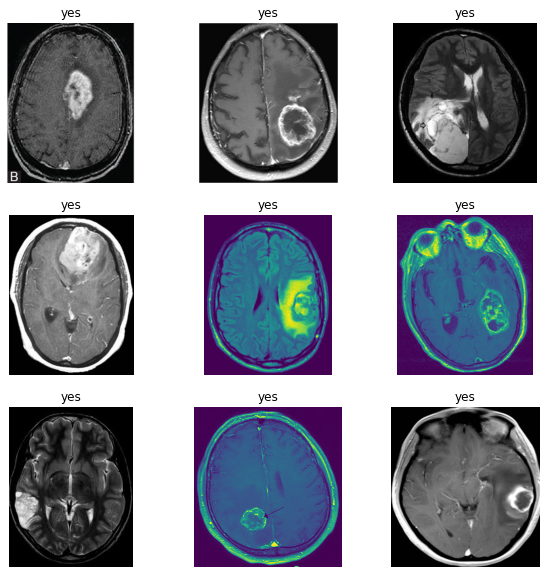

In [24]:
plt.figure(figsize=(10, 10))
for i in range(9):
  img = path[i]
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(plt.imread(img))
  plt.title(os.path.split(os.path.split(img)[0])[-1])
  plt.axis("off")

* 데이터 로드 클래스 (변경하지 마세요!)

In [25]:
# Do not change this class !!
class BrainMRIDataset(Dataset):

    def __init__(self, file_dir, transform):
      self.dataDirectory = file_dir
      self.transform = transform

      self.no_class = glob(file_dir+'/no/*')
      self.yes_class = glob(file_dir+'/yes/*')
      self.file_list = self.no_class + self.yes_class
      self.label_list = [0]*len(self.no_class) + [1]*len(self.yes_class)
      self.dataframe = pd.DataFrame({'image': self.file_list,
                                     'label': self.label_list})  
      self.dataframe = shuffle(self.dataframe)
      self.dataframe.reset_index(inplace=True,drop=True)

    def __len__(self):
      return len(self.no_class)+len(self.yes_class)

    def __getitem__(self, index):
      img_path = self.dataframe['image'][index]
      labels = self.dataframe['label'][index]
      labels = labels.tolist()
      
      if type(img_path) == str:
        img_path = [img_path]

      img_array = []
      for image in img_path:
        img = Image.open(image).convert("RGB")
        img_transformed = self.transform(img)
        array = np.asarray(img_transformed)
        img_array.append(array)
            
      return [torch.tensor(img_array, device=device),torch.tensor(labels, device=device)]
    
    def __repr__(self):
      print("Data loading succeed!!")
      print("-"*100)
      plt.figure(figsize=(10, 10))
      for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(plt.imread(self.file_list[i]))
        plt.title(os.path.split(os.path.split(self.file_list[i])[0])[-1])
        plt.axis("off")

      rep = pd.DataFrame({'File Path' : self.file_list})
      return str(rep.head(9))

# customize your transformation

In [26]:
# you can add other 'torcivision.transforms.'
data_transform = transforms.Compose([
                                     # add transforms
                                     transforms.Resize((128,128)), # do not change resize!!
                                     transforms.ToTensor(),        # do not change totensor!!
                                     ])

In [27]:
# data_transform 을 정의하고, 밑의 코드의 결과값이 모두 (3,128,128)이 나오는지 확인하세요.
path = glob(file_dir+'/yes/*')
for image in path[:5]:
  img = Image.open(image).convert("RGB")
  print(np.asarray(data_transform(img)).shape)

(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)


Data loading succeed!!
----------------------------------------------------------------------------------------------------


                                    File Path
0   archive/brain_tumor_dataset//no/24 no.jpg
1   archive/brain_tumor_dataset//no/27 no.jpg
2    archive/brain_tumor_dataset//no/7 no.jpg
3  archive/brain_tumor_dataset//no/48 no.jpeg
4     archive/brain_tumor_dataset//no/N17.jpg
5     archive/brain_tumor_dataset//no/N16.jpg
6   archive/brain_tumor_dataset//no/30 no.jpg
7   archive/brain_tumor_dataset//no/no 5.jpeg
8    archive/brain_tumor_dataset//no/No15.jpg

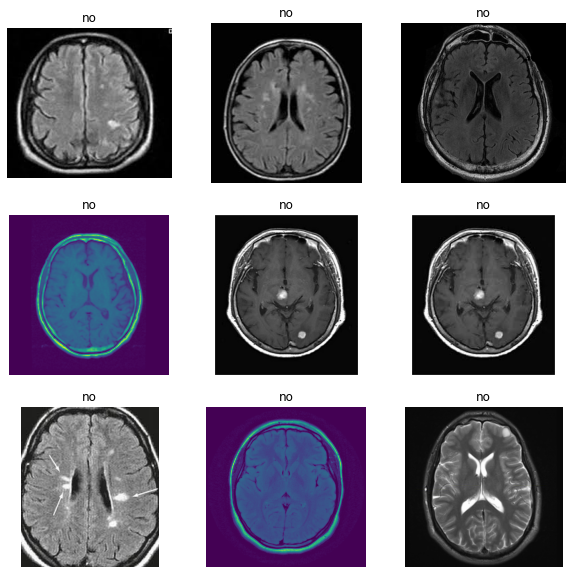

In [28]:
# load the data
dataset = BrainMRIDataset(file_dir, transform = data_transform)
dataset

# 2. Modeing

In [29]:
# can change, but remind the dimension
# First input must be : [1, 3, 128, 128]
# Last output must be : [1, 2]

class BrainTumorModel(nn.Module):
    
    def __init__(self):
        super().__init__()
            # input : [1, 3, 128, 128]
        self.layer1 = nn.Sequential(
          nn.Conv2d(3,16,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.Conv2d(16,16,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2))              # output : [1, 16, 64, 64]
        
        self.layer2 = nn.Sequential(
          nn.Conv2d(16,32,kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(32,32,kernel_size=3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2))              # output : [1, 32, 32, 32]

        # self.layer3 = nn.Sequential(
        #   nn.Conv2d(128,256,kernel_size=3, padding=1),
        #   nn.ReLU(),
        #   nn.Conv2d(256,256,kernel_size=3,padding=1),
        #   nn.ReLU(),
        #   nn.MaxPool2d(2))              # output : [1, 256, 16, 16]

        self.flat = nn.Flatten(1)                 # output : [1, 32*32*32]
        self.linear1 = nn.Linear(32*32*32,32*32)# output : [1, 32*32]
        self.linear2 = nn.Linear(32*32,32*32)   # output : [1, 32*32]
        self.linearout = nn.Linear(32*32,2)      # output : [1, 2]
        self.dropout = nn.Dropout()

    def forward(self,x):
        # input : [1, 3, 128, 128]
        x = (self.layer1(x))       # output : [1, 64, 64, 64]
        x = (self.layer2(x))       # output : [1, 128, 32, 32]
        # x = (self.layer3(x))       # output : [1, 256, 16, 16]

        x = F.relu(self.flat(x))        # output : [1, 128*32*32]
        x = self.dropout(x)
        x = F.relu(self.linear1(x))     # output : [1, 128*32]
        x = self.dropout(x)
        x = F.relu(self.linear2(x))     # output : [1, 128*32]
        x = self.linearout(x)           # output : [1, 2]

        return x

In [30]:
model = BrainTumorModel()
model.to(device)

BrainTumorModel(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (linearout): Linear(in_features=1024, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

# 3. Training

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [32]:
# divide dataset to train and test.
train, test = random_split(dataset, [200, 53],generator=torch.Generator().manual_seed(42))
print("Total number of dataset:",len(dataset))
print("Train dataset:",len(train))
print("Test dataset:",len(test)) 

Total number of dataset: 253
Train dataset: 200
Test dataset: 53


In [33]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [34]:
epochs = 100
batch_size = 8
loss_list = []
for epoch in range(epochs):
    total_loss = 0
    for n in range(len(train)//batch_size):
    
        data, target = train[n*batch_size:(n+1)*batch_size]

        ypred = model.forward(data.float())
        loss = loss_fn(ypred,target.long())

        total_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  
    loss_list.append(total_loss/batch_size)
    if epoch % 5 == 0:
      print(f'Epochs: {epoch} Loss: {total_loss/n}')

Epochs: 0 Loss: 0.7364394068717957
Epochs: 5 Loss: 0.5577722787857056
Epochs: 10 Loss: 0.5051587820053101
Epochs: 15 Loss: 0.449238657951355
Epochs: 20 Loss: 0.3573971688747406
Epochs: 25 Loss: 0.29723060131073
Epochs: 30 Loss: 0.11385560035705566
Epochs: 35 Loss: 0.13245856761932373
Epochs: 40 Loss: 0.06844498962163925
Epochs: 45 Loss: 0.029494455084204674
Epochs: 50 Loss: 0.023186376318335533
Epochs: 55 Loss: 0.004241833928972483
Epochs: 60 Loss: 0.007378473877906799
Epochs: 65 Loss: 0.02223804220557213
Epochs: 70 Loss: 0.0009666073601692915
Epochs: 75 Loss: 0.023590411990880966
Epochs: 80 Loss: 0.09278005361557007
Epochs: 85 Loss: 0.0003465033951215446
Epochs: 90 Loss: 0.00021933834068477154
Epochs: 95 Loss: 0.006774429231882095


# 4. Visualize the result

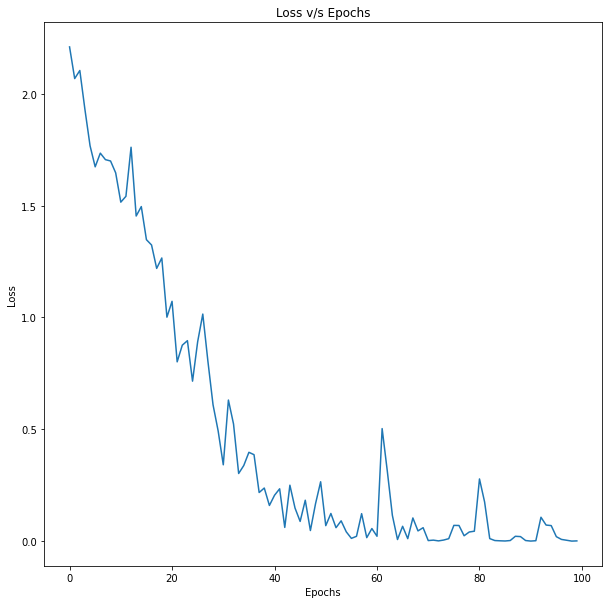

In [35]:
fig = plt.figure(figsize=(10,10))
plt.plot(list(range(epochs)),loss_list)
plt.title("Loss v/s Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# 5. Testing

In [36]:
correct = 0
total = 0

with torch.no_grad():
  for data in test:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images.float())
        
    _, predicted = torch.max(outputs.data, 1)
        
    total += 1
        
    correct += (predicted == labels).sum().item()

print('Accuracy of test images: %d %%' % (
    100 * correct / total))

Accuracy of test images: 86 %
